In [1]:
##import libraries
import pandas as pd
import evaluate
import os
import json
import io
from sklearn.model_selection import train_test_split
from peft import get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline,Trainer
from sentence_transformers import SentenceTransformer, util
from peft import LoraConfig, TaskType,get_peft_model
from datasets import Dataset, load_dataset,load_from_disk
import torch
from trl import SFTTrainer
from itertools import zip_longest
from tqdm import tqdm
import gc
from dataclasses import dataclass, field
from typing import Dict

import datasets
from loss import FocalLoss, GDiceLoss, SelfAdjDiceLoss, lovasz_softmax_flat
from torch.utils.data import DataLoader, Dataset, IterableDataset
from transformers.trainer_utils import seed_worker

from utils import MetricsCalculator
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import langextract as lx
import traceback

In [2]:
#link to gemini chat to copy files: https://gemini.google.com/app/e082f002134af636

In [16]:
##Evaluation Configs
##model_name: name of the model to evaluate
model_name = "Qwen2-1.5B-Instruct"
task = "recipe_nlg"
baseline_name = "Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-09-15-12-52-36"
##experiment_name : experiment to evaluate against Sota

In [17]:
#TODO: make configuration file to point to all files containing metrics for each experiment.
#In this way, you can start to work on BLEU,ROUGE and BERTScore while waiting for the rest of scores

In [18]:
##load baseline and ground truth
file_path_baseline = f"eval/{baseline_name}_metrics.parquet"
# Read the Parquet file into a pandas DataFrame
df_metrics = pd.read_parquet(file_path_baseline)

# Display the first 10 lines of the DataFrame
print(df_metrics.columns)

Index(['experiment_name', 'mean', 'std', 'metric'], dtype='object')


In [19]:
def graph_metrics_bar_chart(metric_df, metrics):
    """
    Create bar chart comparing mean metric scores across experiments
    """
    
    
    # Create grouped bar chart
    fig = px.bar(
        metric_df, 
        x='metric', 
        y='mean',
        color='experiment_name',
        barmode='group',
        title='Mean Metric Scores by Experiment',
        labels={'mean_score': 'Average Score', 'metric': 'Metric'},
        #error_y='std'  # Add error bars
    )
    
    fig.update_layout(
        width=1400,
        height=800,
        showlegend=True,
        xaxis_title='Metrics',
        yaxis_title='Average Score'
    )
    
    fig.show()
    return fig

In [20]:
df_metrics

,experiment_name,mean,std,metric
0,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.288721,0.075706,BLEU
1,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.303910,0.093645,ROUGE1
2,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.054696,0.044909,ROUGE2
3,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.222696,0.071092,ROUGEL
4,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.889440,0.016064,BERTSCORE_F1
5,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.900093,0.018860,BERTSCORE_PRECISION
6,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.879295,0.019904,BERTSCORE_RECALL
7,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.263173,0.252092,action_precision
8,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.565217,0.501206,temperature_precision
9,Qwen3-4B-CrossEntropyLoss-long-RecipeNLG-2025-...,0.434783,0.489997,time_precision


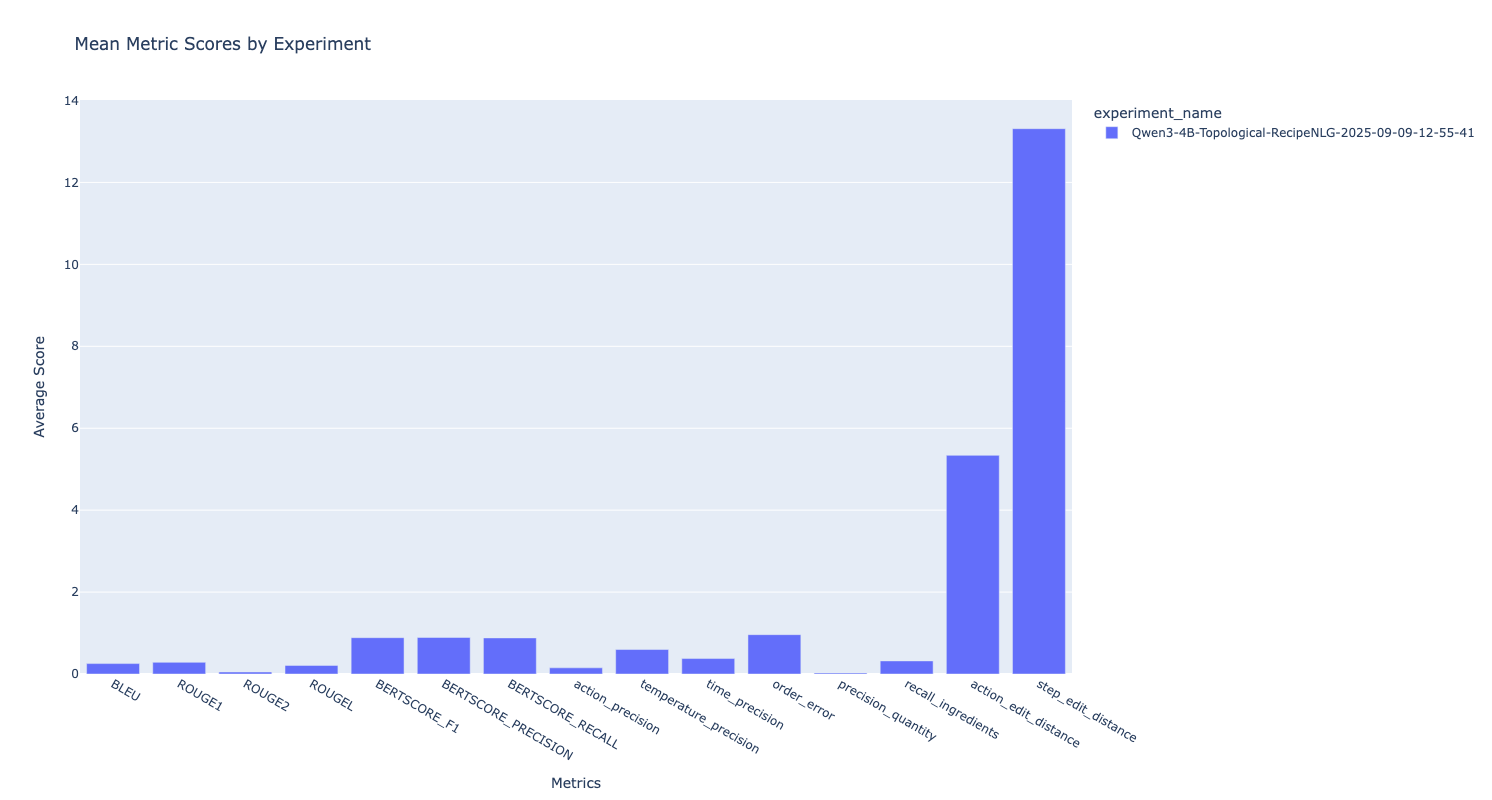

In [32]:
metrics = df_metrics['metric'].unique().tolist()
df_metrics_no_length = df_metrics[df_metrics['metric'] != 'LENGTH']
fig2 = graph_metrics_bar_chart(df_metrics_no_length, metrics)

In [37]:
# To run this script, you first need to install the necessary libraries.
# You can do this by running the following command in your terminal:
# pip install sentence-transformers torch

import torch
from sentence_transformers import SentenceTransformer, util

def get_word_similarity(word1: str, word2: str, model: SentenceTransformer) -> float:
    """
    Calculates the cosine similarity between two words using a pre-loaded model.

    Args:
        word1 (str): The first word.
        word2 (str): The second word.
        model (SentenceTransformer): The pre-loaded sentence transformer model.

    Returns:
        float: The cosine similarity score, ranging from -1 (opposite) to 1 (identical).
    """
    try:
        # 1. Encode the words into vector embeddings
        # The model converts each word into a high-dimensional numerical vector.
        embedding1 = model.encode(word1, convert_to_tensor=True)
        embedding2 = model.encode(word2, convert_to_tensor=True)

        # 2. Compute cosine similarity
        # This function calculates the cosine of the angle between the two vectors.
        # A value of 1 means they are identical, 0 means they are unrelated, and -1 means they are opposites.
        cosine_score = util.pytorch_cos_sim(embedding1, embedding2)

        # 3. Return the numerical value from the tensor
        return cosine_score.item()

    except Exception as e:
        print(f"An error occurred: {e}")
        return 0.0

# Load a pre-trained model. 'all-MiniLM-L6-v2' is a good, lightweight choice.
print("Loading the embedding model...")
# This might take a moment the first time you run it as it downloads the model.
model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')
print("Model loaded successfully.\n")

# --- Define the words you want to compare ---
word_a = "king"
word_b = "queen"

word_c = "cook"
word_d = "bake"

word_e = "apple"
word_f = "car"

# --- Calculate and print the similarity scores ---
similarity_ab = get_word_similarity(word_a, word_b, model)
print(f"Similarity between '{word_a}' and '{word_b}': {similarity_ab:.4f}")

similarity_cd = get_word_similarity(word_c, word_d, model)
print(f"Similarity between '{word_c}' and '{word_d}': {similarity_cd:.4f}")

similarity_ef = get_word_similarity(word_e, word_f, model)
print(f"Similarity between '{word_e}' and '{word_f}': {similarity_ef:.4f}")


Loading the embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Model loaded successfully.

Similarity between 'king' and 'queen': 0.7943
Similarity between 'cook' and 'bake': 0.7998
Similarity between 'apple' and 'car': 0.5744


In [92]:
word_a = "orange"
word_b = "mandarin"
model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')
similarity_ab = get_word_similarity(word_a, word_b, model)
print(f"Similarity between '{word_a}' and '{word_b}': {similarity_ab:.4f}")

Similarity between 'orange' and 'mandarin': 0.6995


In [93]:
model = SentenceTransformer('all-MiniLM-L6-v2')
similarity_ab = get_word_similarity(word_a, word_b, model)
print(f"Similarity between '{word_a}' and '{word_b}': {similarity_ab:.4f}")

Similarity between 'orange' and 'mandarin': 0.4457
